# Notebook - Attribution Analysis

## Import modules

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import omegaconf
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
# === Load configuration file
config_path = "../config/config.yaml"
config = omegaconf.OmegaConf.load(config_path)
trained_model_folder_no = config.evaluation.folder_no

In [3]:
# import dataset
source_data_path = "../trained_model/trained_result_"+ str(trained_model_folder_no)+ "/feature_dataset.parquet"
dataset = pd.read_parquet(source_data_path)
# get x and y
x_indic = dataset[["lat","lon","month","sequence"]]

x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","burned_area_mom_conv","burned_area_yoy_conv","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x_indic = np.array(x_indic)
x = np.array(x)
y = np.array(y).reshape(-1, 1)
print(x.shape, y.shape)

(106863, 16) (106863, 1)


## Data Preparation

In [4]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

In [5]:
split_ratio = 0.8
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

In [6]:
train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

In [7]:
X_test = test_x[0:100]
X_train = train_x[0:100]

## Pre-trained Model Load

In [8]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation1 = nn.Tanh()
        self.activation2 = nn.Tanh()
        self.activation3 = nn.Tanh()
        self.activation4 = nn.Tanh()
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation4(x)
        x = self.dropout(x)
        x = self.layer5(x)

        return x

In [9]:
net = network()
net

network(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation1): Tanh()
  (activation2): Tanh()
  (activation3): Tanh()
  (activation4): Tanh()
  (dropout): Dropout(p=0.15, inplace=False)
)

In [10]:
model_param_path = "../trained_model/trained_result_"+ str(trained_model_folder_no)+ "/trained_model.pth"
state_dict = torch.load(model_param_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

## Interpret model - Attribution

In [11]:
ig = IntegratedGradients(net)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(net)
gs = GradientShap(net)
fa = FeatureAblation(net)

In [12]:
ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

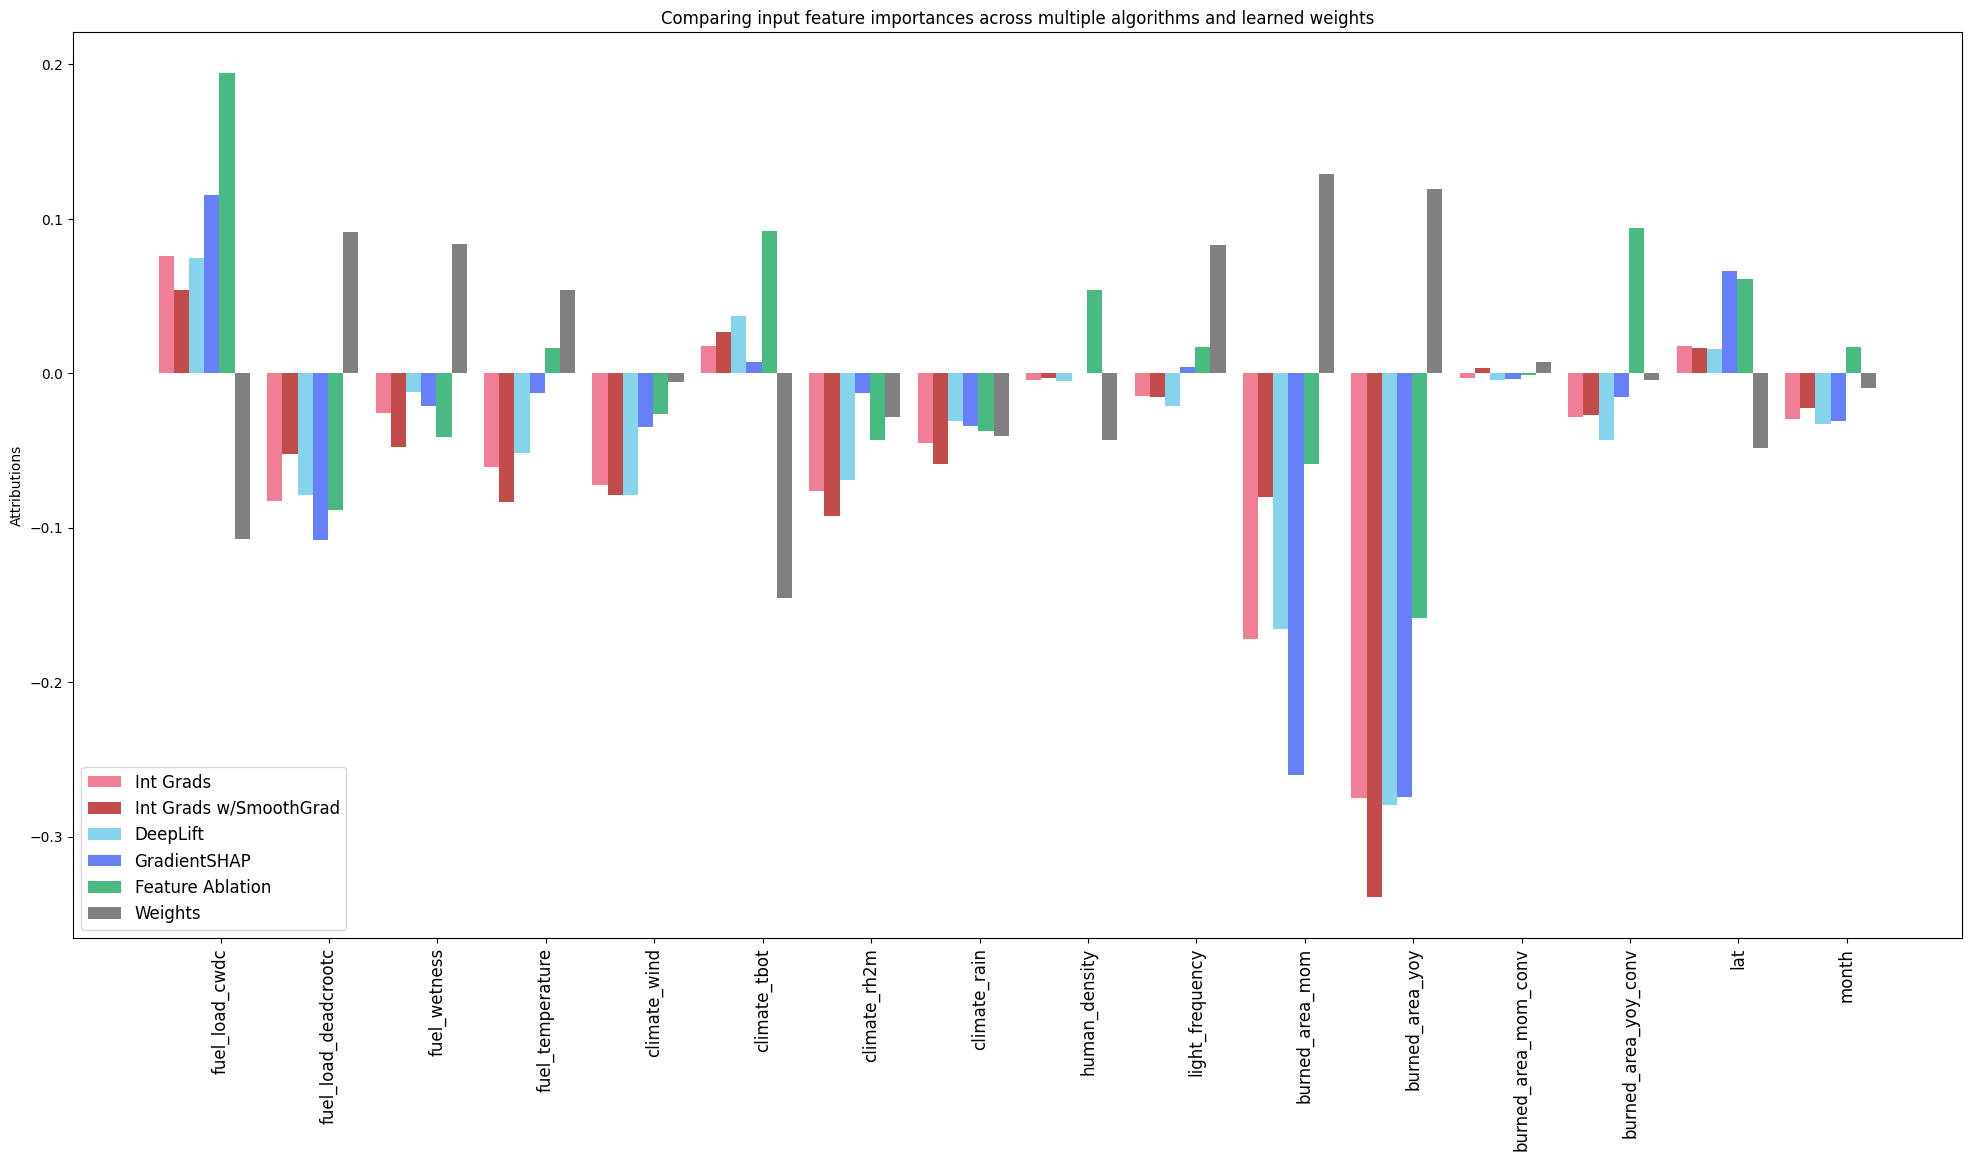

In [13]:
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = ['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","burned_area_mom_conv","burned_area_yoy_conv","lat","month"]

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = net.layer1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels, fontsize = 12, rotation = 90)

plt.legend(legends, loc=3)
plt.show()

### Algorithm

- **Int Grads**: Integrated Gradients.
- **Int Grads w/SmoothGrad**: A variation of Integrated Gradients that includes smoothing to reduce noise.
- **DeepLift**: A technique that compares the activation of each neuron to a reference value and assigns importance scores accordingly.
- **GradientSHAP**: A method that combines SHAP (SHapley Additive exPlanations) values with gradients.
- **Feature Ablation**: This method measures the effect of setting each feature value to a baseline value (often zero) and observing the difference in output.
- **Weights**: The actual learned weights of the model. This is often a baseline for comparison as it shows what the model has learned without any interpretation method.

### Insights Summary

1. **Time-Series and Seasonal Effect**:

   The weights show the correlation between the independent and dependent variables. The grey bars in the figure reveal the correlation between the independent variables and the dependent variable. In this case, "burned_area_mom" and "burned_area_yoy" are positively correlated with the dependent variable, which is in line with normal expectations and understanding. Typically, areas that have burned a large area previously will also maintain a relatively large burned area in the future.

2. **Convolutional Features help to set burned area caps for predictions**:

    The value of burned area after convolution pooling has a negative correlation with the dependent variable. The algorithm for this variable is obtained by taking the information of this grid and the surrounding grids for convolution and calculating it by maximum pooling. Therefore, it can be interpreted as an augmented value of the burned area of that region and its surrounding extended regions that tells the model its cap of burned values, thus mitigating the model's overprediction of burned values.

3. **Other Factors**

   It is well noted that "human density" shows less impact and contribution to the modeling.

2. **Inverse Relationship between weights and scores**

   Attribution algorithms sometimes disagree in assigning importance scores and they are not always consistent with weights. However, we can still observe the two most important features and according to most attribution algorithms and weight scores are also considered important. And, the positive and negative values of the imputation algorithms may be related to the choice of the baseline. In this figure, we use a zero-valued baseline for all features, but the situation changes if we choose these values more carefully for each feature.

**Reference**

[Captum · Model Interpretability for PyTorch](https://captum.ai/tutorials/House_Prices_Regression_Interpret)

## Attributing to the layers and comparing with model weights

In [14]:
def layer_neuron_parse(layer = 1):
    if layer == 1:
        lays = net.layer1
    elif layer == 2:
        lays = net.layer2
    elif layer == 3:
        lays = net.layer3
    elif layer == 4:
        lays = net.layer4
    elif layer == 5:
        lays = net.layer5

    # Compute the attributions of the output with respect to the inputs of the fourth linear layer
    lc = LayerConductance(net, lays)
    # shape: test_examples x size_hidden
    lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)
    # weights from forth linear layer
    # shape: size_hidden4 x size_hidden3
    lin4_weight = lays.weight
    plt.figure(figsize=(15, 8))
    x_axis_data = np.arange(lc_attr_test.shape[1])
    y_axis_lc_attr_test = lc_attr_test.mean(0).detach().numpy()
    y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)
    y_axis_lin4_weight = lin4_weight[0].detach().numpy()
    y_axis_lin4_weight = y_axis_lin4_weight / np.linalg.norm(y_axis_lin4_weight, ord=1)
    width = 0.25
    legends = ['Attributions','Weights']
    x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]
    ax = plt.subplot()
    ax.set_title('Aggregated neuron importances and learned weights in the last linear layer of the model - Layer '+str(layer))
    ax.bar(x_axis_data + width, y_axis_lc_attr_test, width, align='center', alpha=0.5, color='red')
    ax.bar(x_axis_data + 2 * width, y_axis_lin4_weight, width, align='center', alpha=0.5, color='green')
    plt.legend(legends, loc=2, prop={'size': 20})
    ax.autoscale_view()
    plt.tight_layout()
    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_labels, fontsize = 12, rotation = 90)
    plt.show()

### Neuron Analysis
The distribution of neurons is more balanced. Among them, neurons four and eight in the first layer contribute less; neuron six in the fourth layer contributes less. From the mention, most of the neuron's have contribution and are in active state

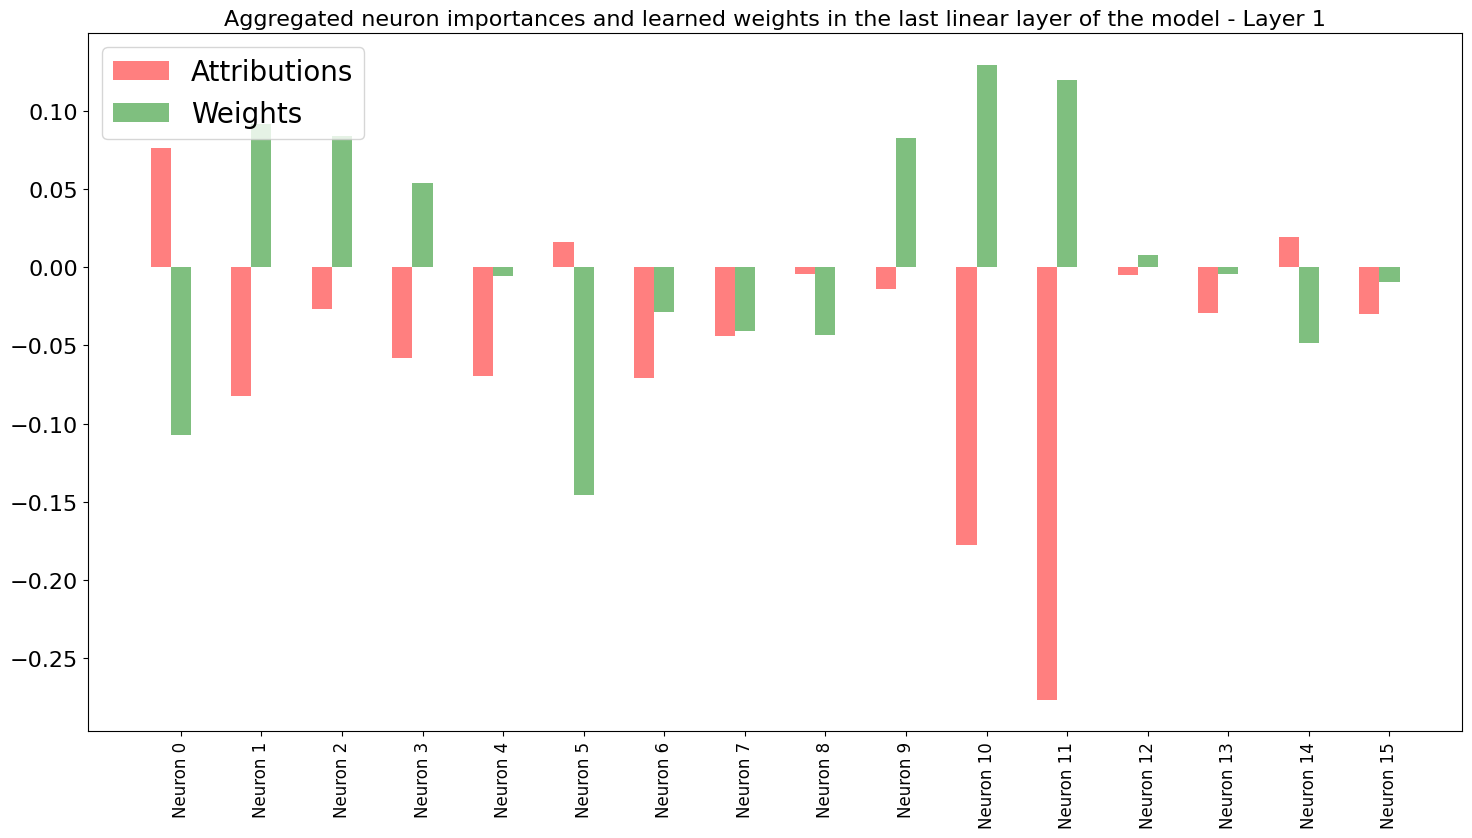

In [15]:
layer_neuron_parse(layer = 1)

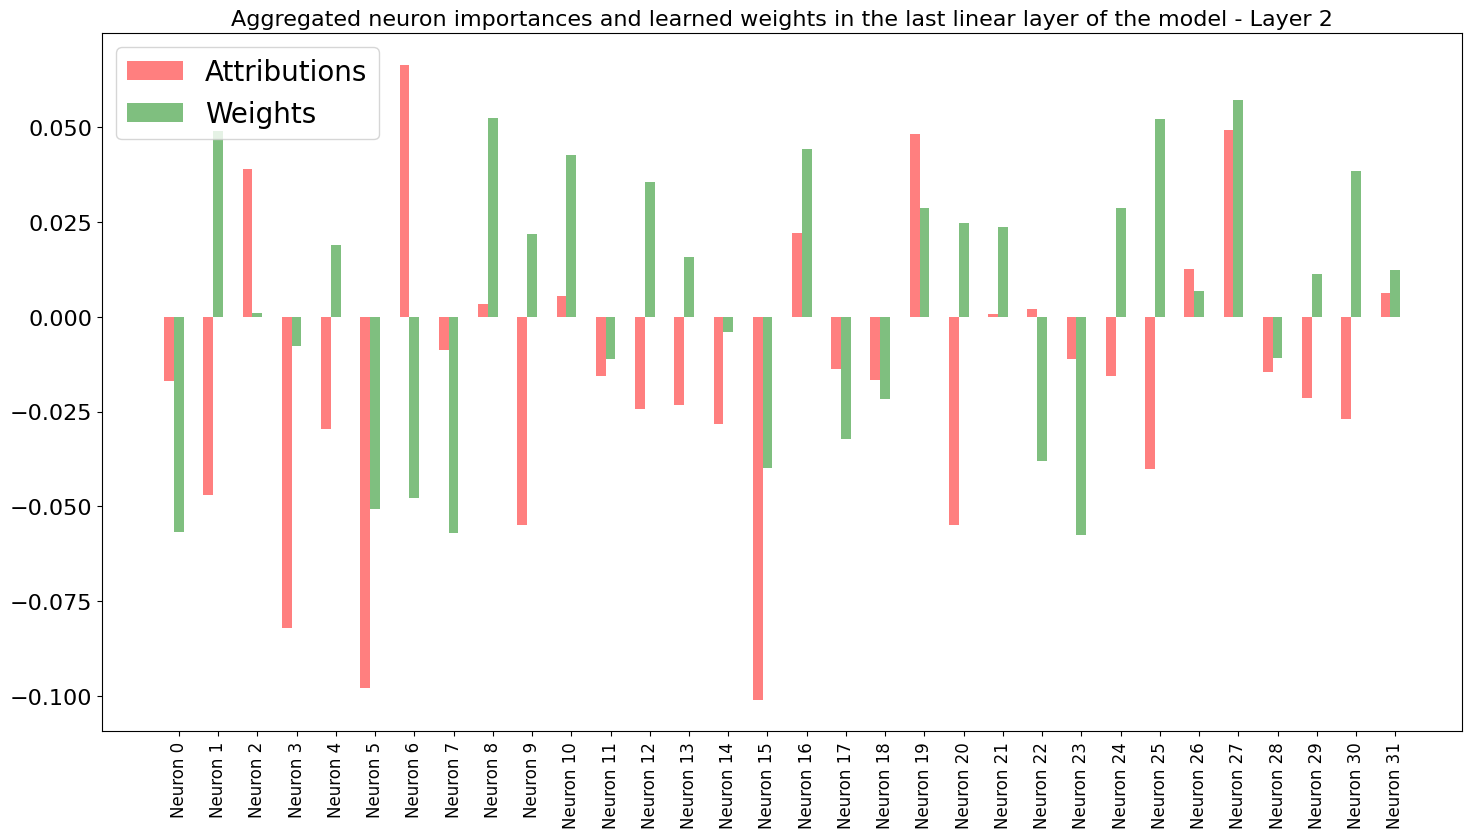

In [16]:
layer_neuron_parse(layer = 2)

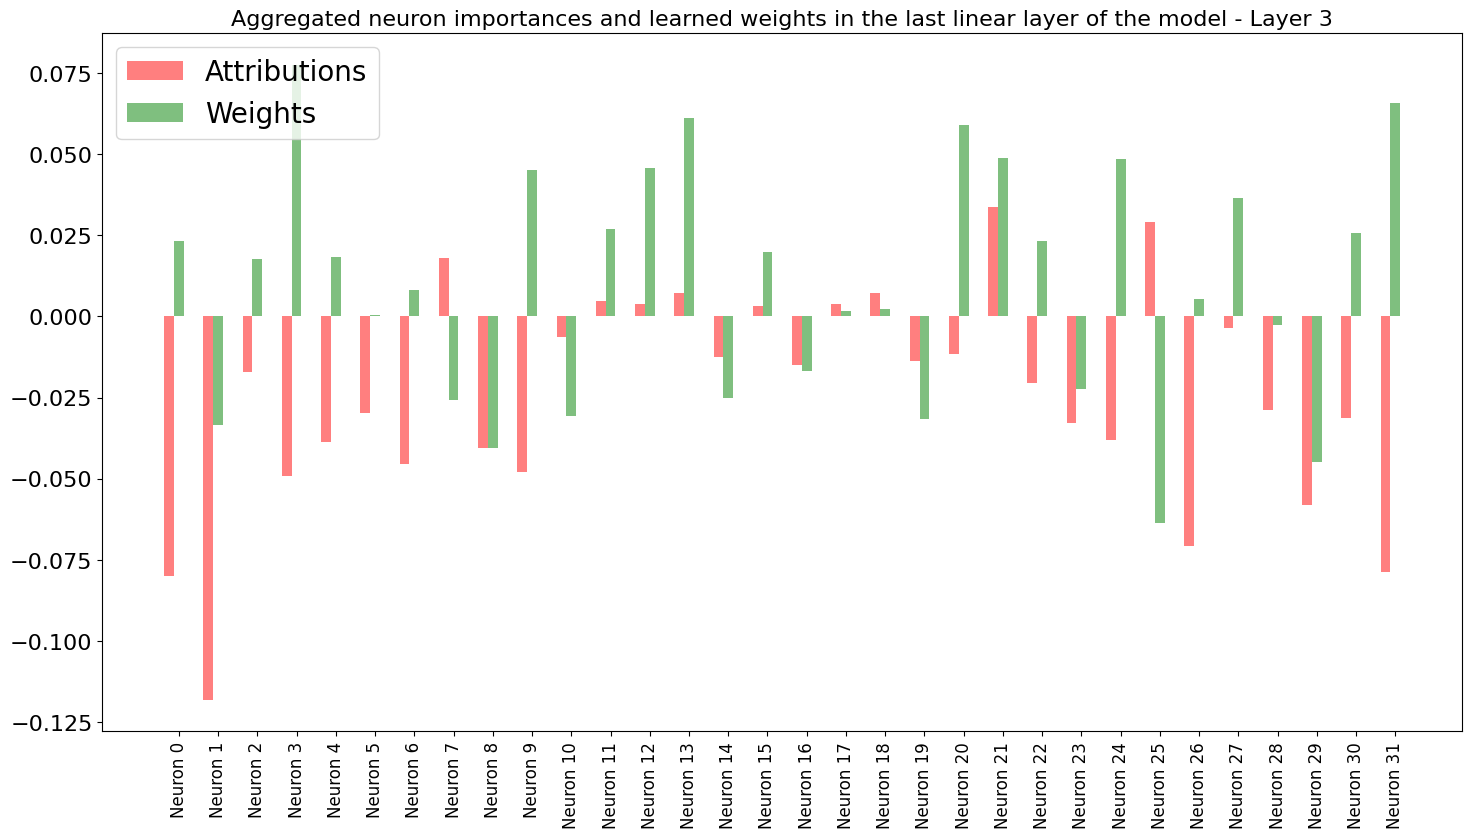

In [17]:
layer_neuron_parse(layer = 3)

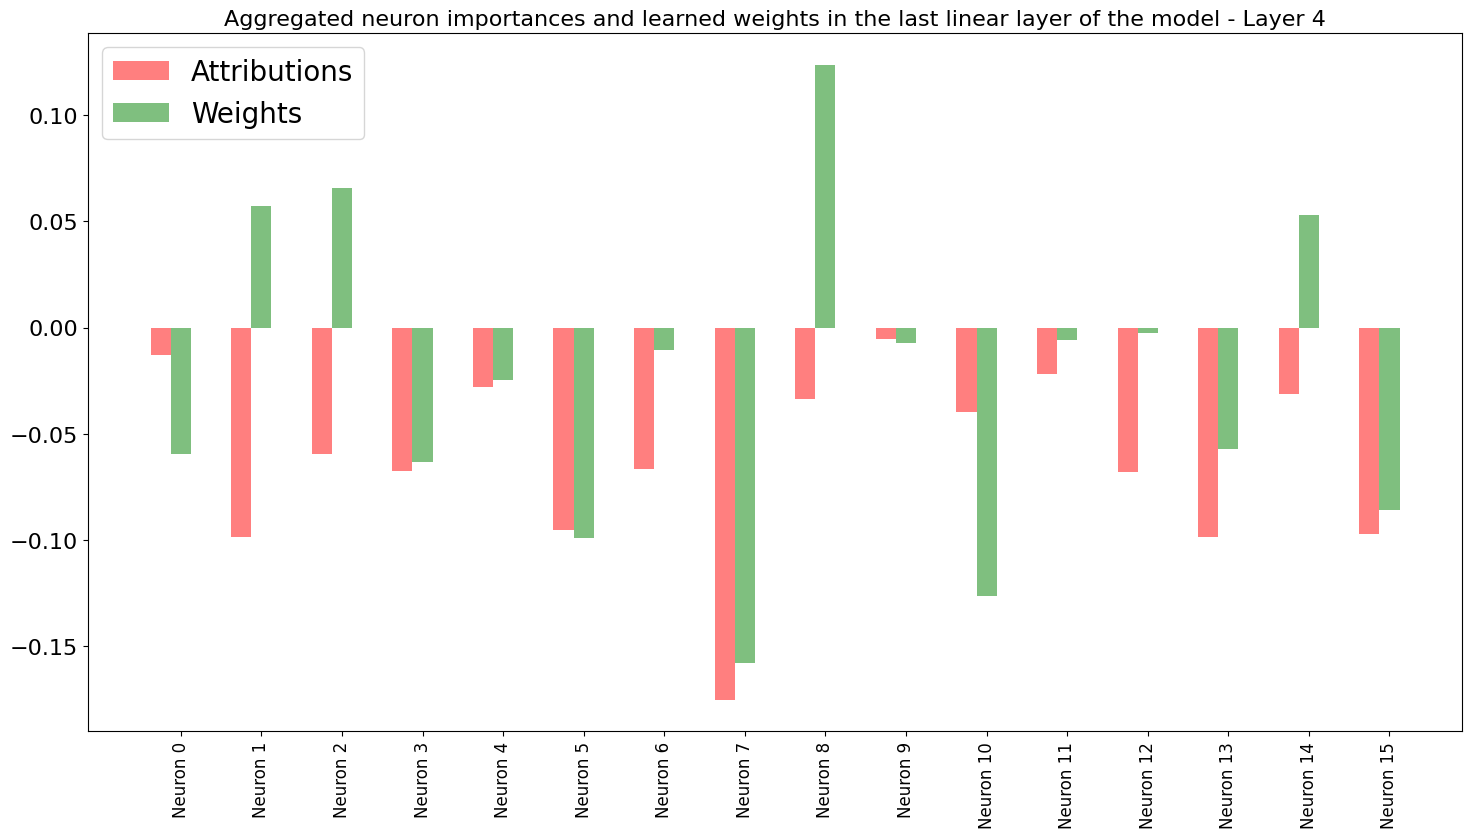

In [18]:
layer_neuron_parse(layer = 4)

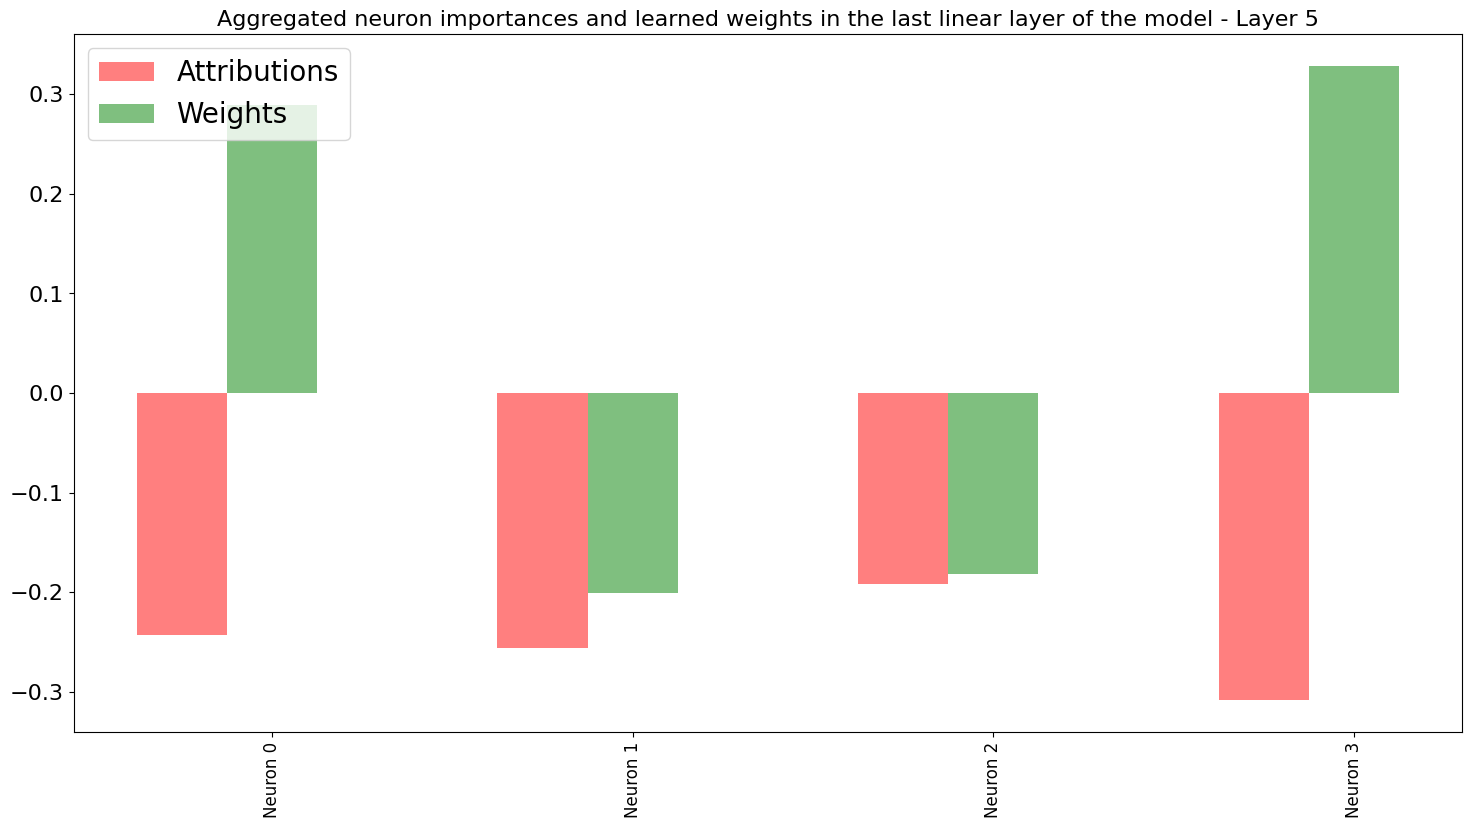

In [19]:
layer_neuron_parse(layer = 5)